In [1]:
from eventio import SimTelFile
import pandas as pd
import numpy as np
import pickle as pkl
import sys
import time
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [2]:
def test(datafilein = "../simtel_data/proton/data/corsika_run1.simtel.gz"):
    #
    sf = SimTelFile(datafilein)
    tic = time.time()
    toc = time.time()
    #
    it_cout = 0
    file_counter=0
    first_evne_in_file=True
    #
    for ev in sf :
        event_id = -999
        #try :
        #    event_id = ev['event_id']
        #except:
        #    event_id == -999

        #if (it_cout%1000==0) :
        #    toc = time.time()
        #    print('{:10d} {:10d} {:10.2f} s'.format(it_cout, event_id, toc - tic))
        #    tic = time.time()

        if (it_cout%1000==0) :
            toc = time.time()
            print('{:10d} {:10.2f} s'.format(it_cout, toc - tic))
            tic = time.time()
        it_cout = it_cout + 1
    
    sf.close()

In [3]:
def print_ev_info(datafilein = "../simtel_data/proton/data/corsika_run1.simtel.gz",evID=1240202):
    sf = SimTelFile(datafilein)
    for ev in sf:
        #
        if (int(ev['event_id']) == int(evID)):
            print("----------------------------------")
            print("event_id         ", ev['event_id'])
            print("energy           ", ev['mc_shower']['energy'])
            print("xcore            ", ev['mc_event']['xcore'])
            print("ycore            ", ev['mc_event']['ycore'])
            print("ev_time          ", ev['telescope_events'][1]['header']['readout_time'])
            print("nphotons         ", len(ev['photons'][0]))
            print("n_pe             ", ev['photoelectrons'][0]['n_pe'])
            print("n_pixels         ", (ev['photoelectrons'][0]['n_pixels']-np.sum(ev['photoelectrons'][0]['photoelectrons']==0)))
            print("wfshape          ", ev['telescope_events'][1]['adc_samples'][0].shape)
            print("type             ", type(ev['telescope_events'][1]['adc_samples'][0]))
            print("typeadc          ", type(ev['telescope_events'][1]['adc_samples'][0][0][0]))
            print("----------------------------------")
            break
    
    sf.close()

In [4]:
def get_wf(datafilein = "../simtel_data/proton/data/corsika_run1.simtel.gz", evID=1240202):
    sf = SimTelFile(datafilein)
    wf=np.array([], dtype=np.uint16)
    for ev in sf:
        if (int(ev['event_id']) == int(evID)):
            wf=ev['telescope_events'][1]['adc_samples'][0]
            break
    
    sf.close()

    return wf

In [5]:
def get_pixel_mapping(datafilein = "../simtel_data/proton/data/corsika_run1.simtel.gz", outmap_csv = 'pixel_mapping.csv'):
    sf = SimTelFile(datafilein)
    #
    n_pixels=float(sf.telescope_descriptions[1]['camera_organization']['n_pixels'])
    n_drawers=float(sf.telescope_descriptions[1]['camera_organization']['n_drawers'])
    pixel_size=float(sf.telescope_descriptions[1]['camera_settings']['pixel_size'][0])
    #
    the_map=np.concatenate((sf.telescope_descriptions[1]['camera_settings']['pixel_x'].reshape(int(n_pixels),1),
                            sf.telescope_descriptions[1]['camera_settings']['pixel_y'].reshape(int(n_pixels),1),
                            sf.telescope_descriptions[1]['camera_organization']['drawer'].reshape(int(n_pixels),1)), axis=1)
    np.savetxt(outmap_csv, the_map, delimiter=' ',fmt='%f')
    #
    print('n_pixels   = ', int(n_pixels))
    print('n_drawers  = ', int(n_drawers))
    print('pixel_size = ', pixel_size)
    #
    # 0.024300
    # 0.023300
    #
    sf.close()

In [6]:
def rolling_window_sum(arr, window_size, axis):
    cumsum = np.cumsum(arr, axis=axis)
    cumsum_shifted = np.roll(cumsum, shift=1, axis=axis)
    cumsum_shifted[:, 0] = 0  # Set the first element to 0
    return cumsum - cumsum_shifted

In [7]:
def def_clusters_info( n_clusters=0, n_points=0,
                       x_mean=-999.0, y_mean=-999.0, t_mean=-999.0,
                       channelID=-999, timeID=-999):
    clusters_info={'n_clusters':int(n_clusters),
                   'n_points':int(n_points),
                   'x_mean':x_mean,
                   'y_mean':y_mean,
                   't_mean':t_mean,
                   'channelID':int(channelID),
                   'timeID':int(timeID)}
    return clusters_info

In [8]:
df = pd.read_csv('../simtel_data/proton/npe_csv/corsika_run1.npe.csv')

In [9]:
#test()

In [10]:
df[df['n_pe']>50]

,Unnamed: 0,event_id,energy,azimuth,altitude,h_first_int,xmax,hmax,emax,cmax,xcore,ycore,ev_time,nphotons,n_pe,n_pixels
2,2,5504.0,1.123066,3.220341,1.271500,12663.388672,457.200012,6639.671875,461.428558,460.637756,-200.572037,52.835350,98.220779,18489.0,565.0,275.0
3,3,6409.0,0.122709,2.996659,1.231897,17323.265625,294.000000,9758.931641,294.000000,328.353088,-70.818909,291.579742,-99.639191,282.0,99.0,78.0
4,4,7604.0,0.230914,3.106559,1.238464,13307.477539,516.086975,5728.506348,516.956543,458.041138,7.118546,214.104721,-106.050636,1008.0,56.0,43.0
6,6,8005.0,0.177895,2.964123,1.191779,34326.316406,440.526306,6914.260742,441.000000,458.594757,280.757141,300.257355,-535.798645,642.0,258.0,112.0
9,9,32706.0,0.958457,3.216358,1.133155,33235.796875,291.428558,9817.926758,296.666656,300.552216,747.484558,-172.879349,-1094.908569,312.0,69.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2798,2798,9969107.0,0.642979,2.926653,1.219998,13679.455078,404.666656,7533.285156,404.545441,365.321869,-180.834732,557.983826,-22.941948,380.0,95.0,74.0
2800,2800,9975401.0,0.708993,3.344345,1.154644,14763.840820,262.131134,10521.056641,263.214294,280.543701,576.990051,-643.632751,-890.937439,205.0,65.0,52.0
2802,2802,9975408.0,0.708993,3.344345,1.154644,14763.840820,262.131134,10521.056641,263.214294,280.543701,513.955627,-642.985596,-830.090576,289.0,103.0,69.0
2805,2805,9993705.0,1.014231,3.137933,1.209304,22244.279297,270.000000,10326.268555,270.000000,276.364532,-362.256805,-333.659271,315.450348,1360.0,94.0,60.0


In [11]:
evID=5504
#evID=1240202
#evID=94302
#print_ev_info(evID=)
print_ev_info(evID=evID)

----------------------------------
event_id          5504
energy            1.1230659484863281
xcore             -200.57203674316406
ycore             52.835350036621094
ev_time           98.22077941894531
nphotons          18489
n_pe              565
n_pixels          275
wfshape           (7987, 75)
type              <class 'numpy.ndarray'>
typeadc           <class 'numpy.uint16'>
----------------------------------


In [12]:
wf=get_wf(evID=evID)
print("wfshape          ", wf.shape)
print("type             ", type(wf))
print("typeadc          ", type(wf[0][0]))

wfshape           (7987, 75)
type              <class 'numpy.ndarray'>
typeadc           <class 'numpy.uint16'>


In [13]:
max_wf=np.amax(wf,axis=1)

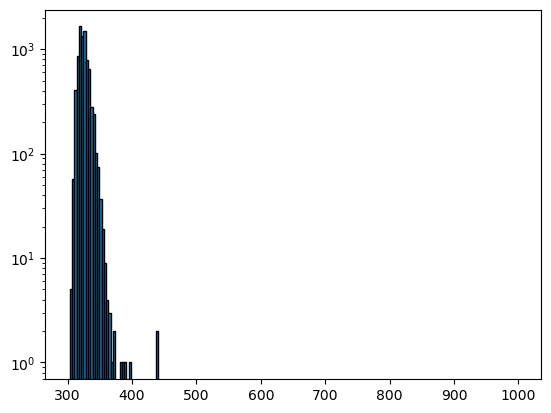

In [14]:
plt.hist(max_wf, bins=np.linspace(300, 1000, num=200), edgecolor='black')
# Add labels and title
#plt.xlabel('npe')
#plt.ylabel('')
#plt.title('npe')
plt.yscale('log')  # Set y-axis to logarithmic scale
#plt.grid(True)
# Show the plot
plt.show()

In [15]:
np.argmax(max_wf)

7513

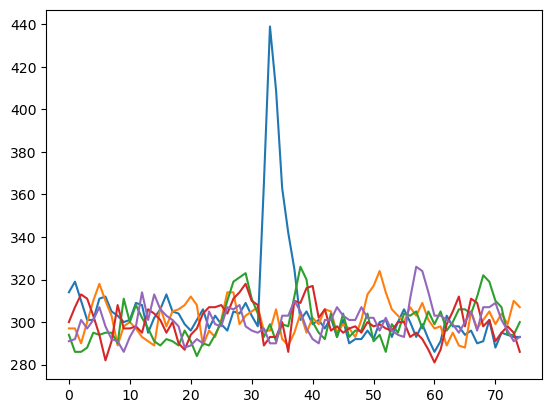

In [16]:
plt.plot(wf[np.argmax(max_wf)])
plt.plot(wf[4426])
plt.plot(wf[7312])
plt.plot(wf[7311])
plt.plot(wf[1])

In [17]:
#get_pixel_mapping()

In [18]:
wf[[0,2,4]]

array([[295, 288, 303, 294, 303, 308, 303, 288, 293, 308, 304, 303, 298,
        294, 293, 292, 292, 288, 292, 290, 292, 285, 293, 295, 304, 304,
        297, 290, 296, 302, 306, 311, 302, 293, 289, 291, 295, 292, 293,
        302, 290, 303, 312, 300, 298, 294, 299, 295, 303, 293, 293, 307,
        307, 311, 319, 321, 313, 306, 300, 303, 286, 290, 301, 297, 296,
        294, 283, 289, 294, 305, 312, 311, 305, 297, 306],
       [306, 297, 310, 302, 305, 308, 318, 314, 318, 310, 325, 313, 303,
        309, 307, 304, 301, 289, 291, 294, 296, 288, 303, 303, 295, 304,
        307, 303, 304, 299, 294, 305, 297, 302, 290, 295, 301, 307, 303,
        289, 298, 294, 288, 289, 295, 292, 303, 298, 302, 302, 292, 283,
        287, 305, 315, 314, 309, 293, 295, 289, 290, 287, 288, 285, 299,
        303, 309, 300, 305, 303, 305, 307, 306, 312, 301],
       [295, 294, 300, 306, 305, 312, 298, 311, 305, 307, 314, 297, 300,
        312, 317, 313, 315, 306, 299, 296, 298, 307, 315, 304, 299, 293,
      

In [19]:
flower_pixID = np.genfromtxt('./pixel_mapping_neighbors.csv',dtype=int)

In [20]:
flower_pixID=flower_pixID+1

In [21]:
print(flower_pixID.shape)

(7987, 6)


In [22]:
flower_seedID=np.arange(1, flower_pixID.shape[0]+1, 1).reshape(flower_pixID.shape[0],1)

In [23]:
flower_pixID=np.concatenate((flower_seedID, flower_pixID), axis=1)

In [24]:
print(flower_pixID)

[[   1    2    3 ...    5    6    7]
 [   2    1    3 ...   13   46   47]
 [   3    1    2 ...   12   13   21]
 ...
 [7985 7955 7961 ... 7981 7984 7986]
 [7986 7954 7955 ... 7981 7985 7987]
 [7987 7969 7970 ... 7982 7986    0]]


In [25]:
flower_pixID[-1]

array([7987, 7969, 7970, 7981, 7982, 7986,    0])

In [26]:
np.sum(flower_pixID[flower_pixID==0])

0

In [27]:
len(flower_pixID[flower_pixID==0])

702

In [28]:
np.sum(wf[[0,2,4]])

67590

In [29]:
np.sum(wf)

179742382

In [30]:
wf.shape

(7987, 75)

In [31]:
wfp=wf.copy()

In [32]:
wfp=np.pad(wfp, pad_width=1)

In [33]:
wfpsl = wfp.copy()

In [34]:
wfpsr = wfp.copy()

In [35]:
wfpsl=np.roll(wfpsl, shift=-1,axis=1)

In [36]:
wfpsr=np.roll(wfpsr, shift=1,axis=1)

In [37]:
wfpsl

array([[  0,   0,   0, ...,   0,   0,   0],
       [295, 288, 303, ..., 306,   0,   0],
       [291, 292, 301, ..., 293,   0,   0],
       ...,
       [295, 290, 289, ..., 299,   0,   0],
       [310, 305, 304, ..., 321,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint16)

In [38]:
wfpsr

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0, 295, ..., 305, 297, 306],
       [  0,   0, 291, ..., 296, 291, 293],
       ...,
       [  0,   0, 295, ..., 294, 288, 299],
       [  0,   0, 310, ..., 313, 306, 321],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint16)

In [39]:
wfpsl.shape

(7989, 77)

In [40]:
wfp=wfpsl + wfpsr + wfp

In [41]:
wfp

array([[  0,   0,   0, ...,   0,   0,   0],
       [295, 583, 886, ..., 908, 603, 306],
       [291, 583, 884, ..., 880, 584, 293],
       ...,
       [295, 585, 874, ..., 881, 587, 299],
       [310, 615, 919, ..., 940, 627, 321],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint16)

In [42]:
len(wfp[0])

77

In [43]:
wfp[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint16)

In [44]:
digitalsum=np.array([np.sum(wfp[flower_pixID[i]],axis=0) for i in np.arange(0,len(flower_pixID))])

In [45]:
digitalsum

array([[2081, 4138, 6247, ..., 6269, 4168, 2085],
       [2081, 4166, 6285, ..., 6325, 4204, 2107],
       [2079, 4138, 6233, ..., 6276, 4183, 2098],
       ...,
       [2082, 4135, 6228, ..., 6190, 4125, 2076],
       [2115, 4215, 6319, ..., 6365, 4257, 2154],
       [1811, 3594, 5362, ..., 5576, 3729, 1886]], dtype=uint64)

In [46]:
wfp[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint16)

In [47]:
len(wfp)

7989

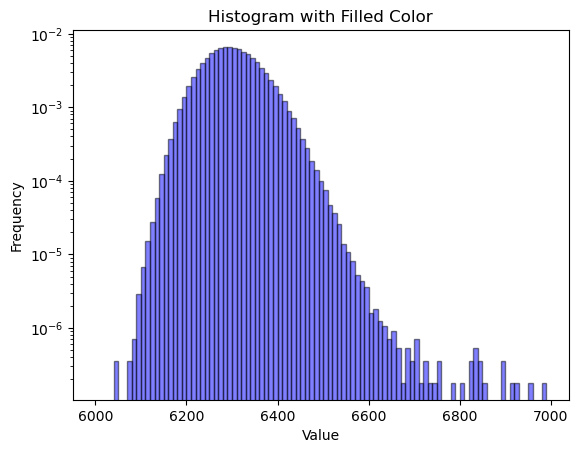

In [48]:
plt.hist(digitalsum.flatten(), bins=np.arange(6000,7000,10), density=True, alpha=0.5, color='blue', edgecolor='black')
# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.ylabel('Frequency')
plt.yscale('log')  # Set y-axis to logarithmic scale

plt.title('Histogram with Filled Color')

# Show plot
plt.show()

In [49]:
digitalsum

array([[2081, 4138, 6247, ..., 6269, 4168, 2085],
       [2081, 4166, 6285, ..., 6325, 4204, 2107],
       [2079, 4138, 6233, ..., 6276, 4183, 2098],
       ...,
       [2082, 4135, 6228, ..., 6190, 4125, 2076],
       [2115, 4215, 6319, ..., 6365, 4257, 2154],
       [1811, 3594, 5362, ..., 5576, 3729, 1886]], dtype=uint64)

In [50]:
nbins=np.linspace(6000, 7000, num=100)

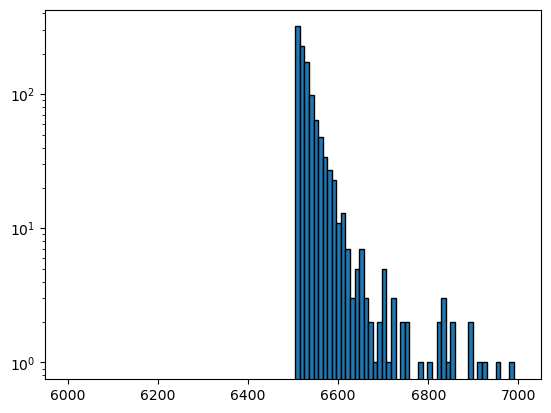

In [51]:
plt.hist(digitalsum[digitalsum>6505].flatten(), bins=nbins, edgecolor='black')
# Add labels and title
#plt.xlabel('npe')
#plt.ylabel('')
#plt.title('npe')
plt.yscale('log')  # Set y-axis to logarithmic scale
#plt.grid(True)
# Show the plot
plt.show()

In [52]:
th=np.array([np.sum(digitalsum>th) for th in nbins])

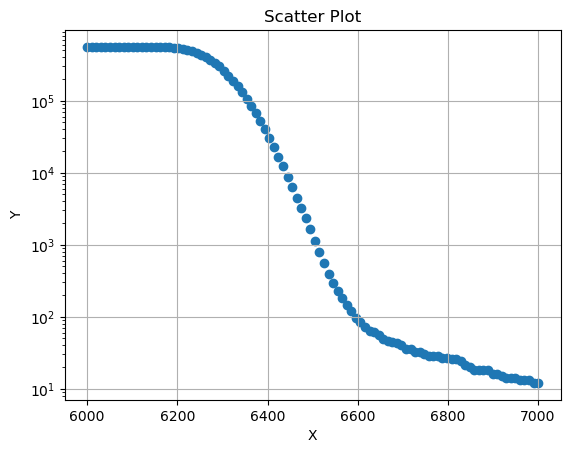

In [53]:

# Create scatter plot
plt.scatter(nbins, th)

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.grid(True)

# Show plot
plt.show()

In [54]:
nbins[th<1000]

array([6515.15151515, 6525.25252525, 6535.35353535, 6545.45454545,
       6555.55555556, 6565.65656566, 6575.75757576, 6585.85858586,
       6595.95959596, 6606.06060606, 6616.16161616, 6626.26262626,
       6636.36363636, 6646.46464646, 6656.56565657, 6666.66666667,
       6676.76767677, 6686.86868687, 6696.96969697, 6707.07070707,
       6717.17171717, 6727.27272727, 6737.37373737, 6747.47474747,
       6757.57575758, 6767.67676768, 6777.77777778, 6787.87878788,
       6797.97979798, 6808.08080808, 6818.18181818, 6828.28282828,
       6838.38383838, 6848.48484848, 6858.58585859, 6868.68686869,
       6878.78787879, 6888.88888889, 6898.98989899, 6909.09090909,
       6919.19191919, 6929.29292929, 6939.39393939, 6949.49494949,
       6959.5959596 , 6969.6969697 , 6979.7979798 , 6989.8989899 ,
       7000.        ])

In [55]:
wf.shape

(7987, 75)

In [56]:
digitalsum.shape

(7987, 77)

In [57]:
len(digitalsum[digitalsum>6505])

1112

In [58]:
digitalsum[:,1:-1].shape

(7987, 75)

In [59]:
digitalsum_rt=digitalsum[:,1:-1]

In [60]:
digitalsum_rt.shape

(7987, 75)

In [61]:
digitalsum_rt

array([[4138, 6247, 6266, ..., 6289, 6269, 4168],
       [4166, 6285, 6326, ..., 6322, 6325, 4204],
       [4138, 6233, 6226, ..., 6290, 6276, 4183],
       ...,
       [4135, 6228, 6228, ..., 6163, 6190, 4125],
       [4215, 6319, 6316, ..., 6311, 6365, 4257],
       [3594, 5362, 5336, ..., 5505, 5576, 3729]], dtype=uint64)

In [62]:
pixelmapping = np.genfromtxt('./pixel_mapping.csv')

In [63]:
pixelmapping.shape

(7987, 3)

(array([ 252.,  733.,  879., 1083., 1001., 1092., 1083.,  879.,  733.,
         252.]),
 array([-1.22058 , -0.976464, -0.732348, -0.488232, -0.244116,  0.      ,
         0.244116,  0.488232,  0.732348,  0.976464,  1.22058 ]),
 <BarContainer object of 10 artists>)

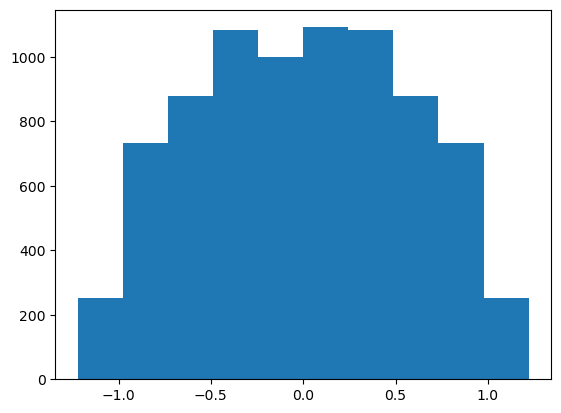

In [64]:
plt.hist(pixelmapping[:,1])

In [65]:
pix_x=pixelmapping[:,0].reshape(pixelmapping.shape[0],1)
pix_y=pixelmapping[:,1].reshape(pixelmapping.shape[0],1)

In [66]:
pix_t=np.array([i for i in np.arange(0,digitalsum_rt.shape[1])]).reshape(1,digitalsum_rt.shape[1])

In [67]:
pix_ID=np.array([i for i in np.arange(0,digitalsum_rt.shape[0])]).reshape(digitalsum_rt.shape[0],1)

In [68]:
pix_t.shape

(1, 75)

In [69]:
pix_ID

array([[   0],
       [   1],
       [   2],
       ...,
       [7984],
       [7985],
       [7986]])

In [70]:
pix_t=pix_t*0.05

In [71]:
pix_t

array([[0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
        1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
        2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
        2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25,
        3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65, 3.7 ]])

In [72]:
pix_x=np.concatenate(([pix_x for i in np.arange(0,digitalsum_rt.shape[1])]), axis=1)
pix_y=np.concatenate(([pix_y for i in np.arange(0,digitalsum_rt.shape[1])]), axis=1)

In [73]:
pixelmapping.shape

(7987, 3)

In [74]:
pix_x

array([[0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.0243 , 0.0243 , 0.0243 , ..., 0.0243 , 0.0243 , 0.0243 ],
       [0.01215, 0.01215, 0.01215, ..., 0.01215, 0.01215, 0.01215],
       ...,
       [1.0206 , 1.0206 , 1.0206 , ..., 1.0206 , 1.0206 , 1.0206 ],
       [1.03275, 1.03275, 1.03275, ..., 1.03275, 1.03275, 1.03275],
       [1.05705, 1.05705, 1.05705, ..., 1.05705, 1.05705, 1.05705]])

In [75]:
pix_t=np.concatenate(([pix_t for i in np.arange(0,digitalsum_rt.shape[0])]), axis=0)

In [76]:
pix_t

array([[0.  , 0.05, 0.1 , ..., 3.6 , 3.65, 3.7 ],
       [0.  , 0.05, 0.1 , ..., 3.6 , 3.65, 3.7 ],
       [0.  , 0.05, 0.1 , ..., 3.6 , 3.65, 3.7 ],
       ...,
       [0.  , 0.05, 0.1 , ..., 3.6 , 3.65, 3.7 ],
       [0.  , 0.05, 0.1 , ..., 3.6 , 3.65, 3.7 ],
       [0.  , 0.05, 0.1 , ..., 3.6 , 3.65, 3.7 ]])

In [77]:
pix_t.shape

(7987, 75)

In [78]:
pix_y.shape

(7987, 75)

In [79]:
pix_ID=np.concatenate(([pix_ID for i in np.arange(0,digitalsum_rt.shape[1])]), axis=1)

In [80]:
pix_ID.shape

(7987, 75)

In [81]:
pix_ID

array([[   0,    0,    0, ...,    0,    0,    0],
       [   1,    1,    1, ...,    1,    1,    1],
       [   2,    2,    2, ...,    2,    2,    2],
       ...,
       [7984, 7984, 7984, ..., 7984, 7984, 7984],
       [7985, 7985, 7985, ..., 7985, 7985, 7985],
       [7986, 7986, 7986, ..., 7986, 7986, 7986]])

In [82]:
cut_y=pix_y[digitalsum_rt>6505]
cut_x=pix_x[digitalsum_rt>6505]
cut_t=pix_t[digitalsum_rt>6505]

In [83]:
cut_ID=pix_ID[digitalsum_rt>6505]

In [84]:
cut_ID

array([  17,   33,   35, ..., 7952, 7952, 7971])

In [85]:
cut_ID.shape

(1112,)

In [86]:
cut_ID=np.expand_dims(cut_ID,axis=1)

In [87]:
cut_ID

array([[  17],
       [  33],
       [  35],
       ...,
       [7952],
       [7952],
       [7971]])

In [88]:
cut_y = np.expand_dims(cut_y,axis=1)

In [89]:
cut_y.shape

(1112, 1)

In [90]:
cut_t.shape

(1112,)

In [91]:
cut_y

array([[ 0.08418],
       [-0.06313],
       [-0.06313],
       ...,
       [ 0.12627],
       [ 0.12627],
       [ 0.08418]])

In [92]:
cut_x = np.expand_dims(cut_x,axis=1)

In [93]:
cut_t = np.expand_dims(cut_t,axis=1)

In [94]:
cut_x

array([[-0.0243 ],
       [-0.06075],
       [ 0.01215],
       ...,
       [ 0.9963 ],
       [ 0.9963 ],
       [ 1.0449 ]])

In [95]:
X=np.concatenate((cut_x,cut_y,cut_t), axis=1)

In [96]:
X.shape

(1112, 3)

In [97]:
dbscan = DBSCAN(eps=0.1, min_samples=20)
clusters = dbscan.fit_predict(X)

In [98]:
len(clusters[clusters>=0])

170

In [99]:
cl_ID=np.unique(clusters)

In [100]:
cl_ID

array([-1,  0])

In [101]:
cl_ID=cl_ID[1:]

In [102]:
cl_ID

array([0])

In [103]:
if len(cl_ID) > 0 :
    try:
        clustern = np.max([len(clusters[clusters==clID]) for clID in np.unique(clusters)[1:]])
    except:
        clustern = 0
else:
    clustern = 0

print(len(cl_ID))
print(clustern)

1
170


In [104]:
len(clusters[clusters==0])

170

In [105]:
len(clusters[clusters==1])

0

In [106]:
len(clusters[clusters==2])

0

In [107]:
len(clusters[clusters==3])

0

In [108]:
np.unique(cut_ID[clusters==0])

array([5572, 5573, 5574, 5575, 5576, 5577, 5578, 5803, 5804, 5805, 5817,
       5819, 5820, 6880, 7092, 7093, 7107, 7108, 7119, 7120, 7121, 7122,
       7123, 7124, 7125, 7136, 7137, 7308, 7311, 7312, 7313, 7314, 7324,
       7326, 7336, 7339, 7340, 7341, 7498, 7499, 7502, 7503, 7511, 7514,
       7515, 7516, 7645, 7650, 7658, 7661, 7662, 7663])

In [109]:
wf.shape

(7987, 75)

In [110]:
np.zeros(wf.shape)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [111]:
clss=np.array([],dtype=int)

In [112]:
clss

array([], dtype=int64)

In [113]:
type(clusters[0])

numpy.int64

In [114]:
type(clusters)

numpy.ndarray

In [115]:
clusters

array([-1, -1, -1, ..., -1, -1, -1])

In [116]:
np.empty(shape=(0,), dtype=int)

array([], dtype=int64)

In [117]:
[len(clusters[clusters==clID]) for clID in np.unique(clusters)[1:]]

[170]

In [118]:
np.argmax([len(clusters[clusters==clID]) for clID in np.unique(clusters)[1:]])

0

In [119]:
clusters.shape

(1112,)

In [120]:
np.unique(clusters)[1:]

array([0])

In [121]:
np.unique(clusters)

array([-1,  0])

In [122]:
np.unique(clusters)

array([-1,  0])

In [123]:
pointID=np.unique(clusters)

In [124]:
pointID=pointID[pointID>-1]

In [125]:
pointID

array([0])

In [126]:
np.argmax([len(clusters[clusters==clID]) for clID in pointID])

0

In [127]:
len(clusters[clusters==pointID[0]])

170

In [128]:
ll={'rrr':444}

In [129]:
ll.keys()

dict_keys(['rrr'])

In [130]:
ll

{'rrr': 444}

In [131]:
def_clusters_info()

{'n_clusters': 0,
 'n_points': 0,
 'x_mean': -999.0,
 'y_mean': -999.0,
 't_mean': -999.0,
 'channelID': -999,
 'timeID': -999}

In [132]:
mm=pixelmapping[pixelmapping[:,1] > 0.1]

In [133]:
mmm=mm[mm[:,1]<0.14]

In [134]:
mmmm=mmm[mmm[:,0]<0.14]

In [135]:
mmmmm=mmmm[mmmm[:,0]>0.1]

In [136]:
mmmmm

array([[0.10935, 0.10522, 7.     ],
       [0.1215 , 0.12627, 9.     ],
       [0.13365, 0.10522, 9.     ]])

In [137]:
pixelmapping

array([[0.00000e+00, 0.00000e+00, 0.00000e+00],
       [2.43000e-02, 0.00000e+00, 0.00000e+00],
       [1.21500e-02, 2.10400e-02, 0.00000e+00],
       ...,
       [1.02060e+00, 1.68360e-01, 1.14000e+03],
       [1.03275e+00, 1.47310e-01, 1.14000e+03],
       [1.05705e+00, 1.47310e-01, 1.14000e+03]])

In [142]:
pix_t[0,-1]+0.05

3.75